In [20]:
# 1. Imports
# -------------------------
import os
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, 
    precision_recall_curve, f1_score, confusion_matrix, 
    accuracy_score, precision_score, recall_score
)
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

# ALL REQUIRED MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# BONUS MODEL
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

sns.set(style='whitegrid')
print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [21]:
# -------------------------
# 2. Set Paths (Works on Mac, Windows, Linux)
# -------------------------
from pathlib import Path

# Universal path detection
project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent

processed_folder = project_root / "data" / "processed"
models_folder = project_root / "models"
models_folder.mkdir(exist_ok=True)

train_path = str(processed_folder / "train.csv")
test_path = str(processed_folder / "test.csv")
y_train_path = str(processed_folder / "y_train.csv")
y_test_path = str(processed_folder / "y_test.csv")

X_train = pd.read_csv(train_path)
X_test = pd.read_csv(test_path)
y_train = pd.read_csv(y_train_path).squeeze()
y_test = pd.read_csv(y_test_path).squeeze()

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Class distribution: {y_train.value_counts().to_dict()}")

X_train: (1176, 55), X_test: (294, 55)
Class distribution: {0: 986, 1: 190}


In [22]:
# -------------------------
# 3. Feature Selection: Mutual Information
# -------------------------
mi = mutual_info_classif(X_train, y_train, random_state=42)
mi_series = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)
top_features_mi = mi_series.head(20).index.tolist()  # keep top 20 features
print("Top 20 features by mutual information:")
print(top_features_mi)

# Reduce datasets to top features
X_train_fs = X_train[top_features_mi]
X_test_fs = X_test[top_features_mi]

Top 20 features by mutual information:
['JobRole_Research Director', 'MonthlyIncome', 'OverTime_Yes', 'StockOptionLevel', 'Age', 'JobInvolvement', 'YearsInCurrentRole', 'TotalWorkingYears', 'Department_Human Resources', 'PerformanceRating', 'Gender_Male', 'TrainingTimesLastYear', 'YearsAtCompany', 'Gender_Female', 'JobRole_Manufacturing Director', 'YearsSinceLastPromotion', 'JobLevel', 'HourlyRate', 'YearsWithCurrManager', 'Department_Research & Development']


In [23]:
# -------------------------
# 4. Define Models - ALL REQUIRED MODELS
# -------------------------
models = {
    # ===== REQUIRED MODELS  =====
    "LogisticRegression": LogisticRegression(
        class_weight='balanced', 
        max_iter=1000, 
        random_state=42
    ),
    
    "DecisionTree": DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        class_weight='balanced',
        random_state=42
    ),
    
    "RandomForest": RandomForestClassifier(
        n_estimators=200, 
        class_weight='balanced', 
        random_state=42,
        n_jobs=-1
    ),
    
    "KNN": KNeighborsClassifier(
        n_neighbors=7,
        weights='distance',
        metric='euclidean',
        n_jobs=-1
    ),
    
    # ===== BONUS MODEL =====
    "SVM": SVC(
        kernel='rbf', 
        probability=True, 
        class_weight='balanced', 
        random_state=42
    )
}

print("="*60)
print("MODELS DEFINED")
print("="*60)
print(f"\n✓ Total models: {len(models)}")
print(f"\nRequired models (4):")
print("  1. Logistic Regression")
print("  2. Decision Tree")
print("  3. Random Forest")
print("  4. K-Nearest Neighbors (KNN)")
print(f"\nBonus models (1):")
print("  5. Support Vector Machine (SVM)")
print("\n" + "="*60)

MODELS DEFINED

✓ Total models: 5

Required models (4):
  1. Logistic Regression
  2. Decision Tree
  3. Random Forest
  4. K-Nearest Neighbors (KNN)

Bonus models (1):
  5. Support Vector Machine (SVM)



In [24]:
# -------------------------
# 5. Train, Evaluate, Save Models
# -------------------------
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_fs, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_fs)
    y_proba = model.predict_proba(X_test_fs)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test_fs)
    
    # Metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    print(f"{name} ROC-AUC: {roc_auc:.4f}, F1: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Save model
    model_path = os.path.join(models_folder, f"{name}_model.pkl")
    joblib.dump(model, model_path)
    print(f"{name} saved to {model_path}")
    
    results[name] = {"model": model, "roc_auc": roc_auc, "f1": f1}


Training LogisticRegression...
LogisticRegression ROC-AUC: 0.7822, F1: 0.4371
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.71      0.81       247
           1       0.32      0.70      0.44        47

    accuracy                           0.71       294
   macro avg       0.62      0.71      0.62       294
weighted avg       0.83      0.71      0.75       294

LogisticRegression saved to /Users/benjaminnguyen/Employee_attrition/models/LogisticRegression_model.pkl

Training DecisionTree...
DecisionTree ROC-AUC: 0.7292, F1: 0.3866
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       247
           1       0.32      0.49      0.39        47

    accuracy                           0.75       294
   macro avg       0.61      0.65      0.62       294
weighted avg       0.80      0.75      0.77       294

DecisionTree saved to /Users/benjaminnguyen/Emplo


MODEL PERFORMANCE COMPARISON - ALL METRICS

             Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
               SVM    0.7653     0.3721  0.6809    0.4812   0.7775
LogisticRegression    0.7109     0.3173  0.7021    0.4371   0.7822
      DecisionTree    0.7517     0.3194  0.4894    0.3866   0.7292
               KNN    0.8503     0.6000  0.1915    0.2903   0.6945
      RandomForest    0.8333     0.4375  0.1489    0.2222   0.7498


✓ Comparison saved to models/model_comparison_full.csv


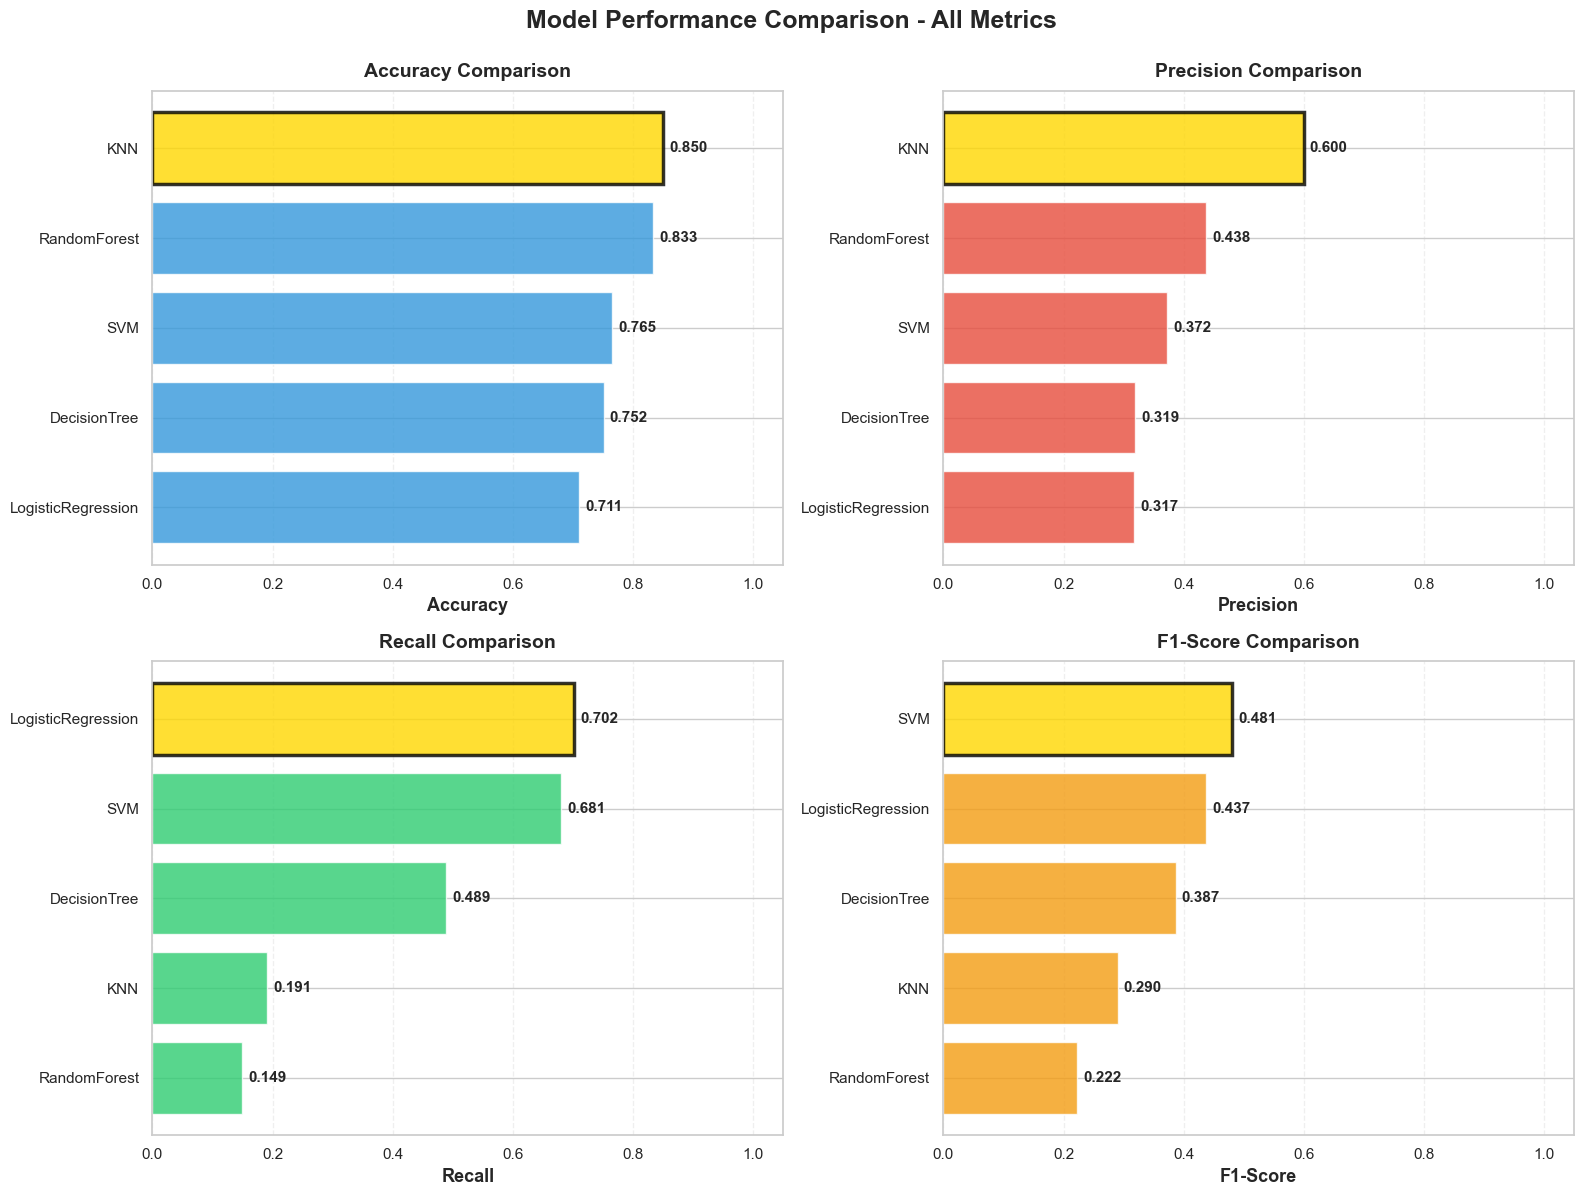


                      🏆 BEST PERFORMING MODEL 🏆                       
Model: SVM

Performance Metrics:
  • Accuracy:  0.7653 (76.53%)
  • Precision: 0.3721 (37.21%)
  • Recall:    0.6809 (68.09%)
  • F1-Score:  0.4812
  • ROC-AUC:   0.7775


In [25]:
# -------------------------
# 6. MODEL PERFORMANCE COMPARISON 
# -------------------------
print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON - ALL METRICS")
print("="*70)

# Calculate all metrics for each model
comparison_data = []
for name in results.keys():
    model = results[name]['model']
    
    # Get predictions
    y_pred = model.predict(X_test_fs)
    y_proba = model.predict_proba(X_test_fs)[:, 1]
    
    # Calculate all metrics
    comparison_data.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    })

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_data).sort_values('F1-Score', ascending=False)

# Display table
print("\n" + comparison_df.to_string(index=False, float_format='%.4f'))
print("\n" + "="*70)

# Save to CSV
comparison_df.to_csv(str(models_folder / 'model_comparison_full.csv'), index=False)
print("\n✓ Comparison saved to models/model_comparison_full.csv")

# Create 4-panel visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison - All Metrics', 
             fontsize=18, fontweight='bold', y=0.995)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Sort by current metric
    sorted_df = comparison_df.sort_values(metric, ascending=True)
    
    # Create bars
    bars = ax.barh(sorted_df['Model'], sorted_df[metric], color=color, alpha=0.8)
    
    # Highlight best model
    best_idx = sorted_df[metric].idxmax()
    bars[list(sorted_df.index).index(best_idx)].set_color('gold')
    bars[list(sorted_df.index).index(best_idx)].set_edgecolor('black')
    bars[list(sorted_df.index).index(best_idx)].set_linewidth(2.5)
    
    # Add value labels
    for bar, value in zip(bars, sorted_df[metric]):
        ax.text(value + 0.01, bar.get_y() + bar.get_height()/2,
               f'{value:.3f}', va='center', fontsize=11, fontweight='bold')
    
    # Styling
    ax.set_xlabel(metric, fontsize=13, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold', pad=10)
    ax.set_xlim([0, 1.05])
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig(str(models_folder / 'model_comparison_clean.png'), 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Print best model summary
best_model_name = comparison_df.iloc[0]['Model']
best_metrics = comparison_df.iloc[0]

print(f"\n{'🏆 BEST PERFORMING MODEL 🏆':^70}")
print("="*70)
print(f"Model: {best_model_name}")
print(f"\nPerformance Metrics:")
print(f"  • Accuracy:  {best_metrics['Accuracy']:.4f} ({best_metrics['Accuracy']*100:.2f}%)")
print(f"  • Precision: {best_metrics['Precision']:.4f} ({best_metrics['Precision']*100:.2f}%)")
print(f"  • Recall:    {best_metrics['Recall']:.4f} ({best_metrics['Recall']*100:.2f}%)")
print(f"  • F1-Score:  {best_metrics['F1-Score']:.4f}")
print(f"  • ROC-AUC:   {best_metrics['ROC-AUC']:.4f}")
print("="*70)

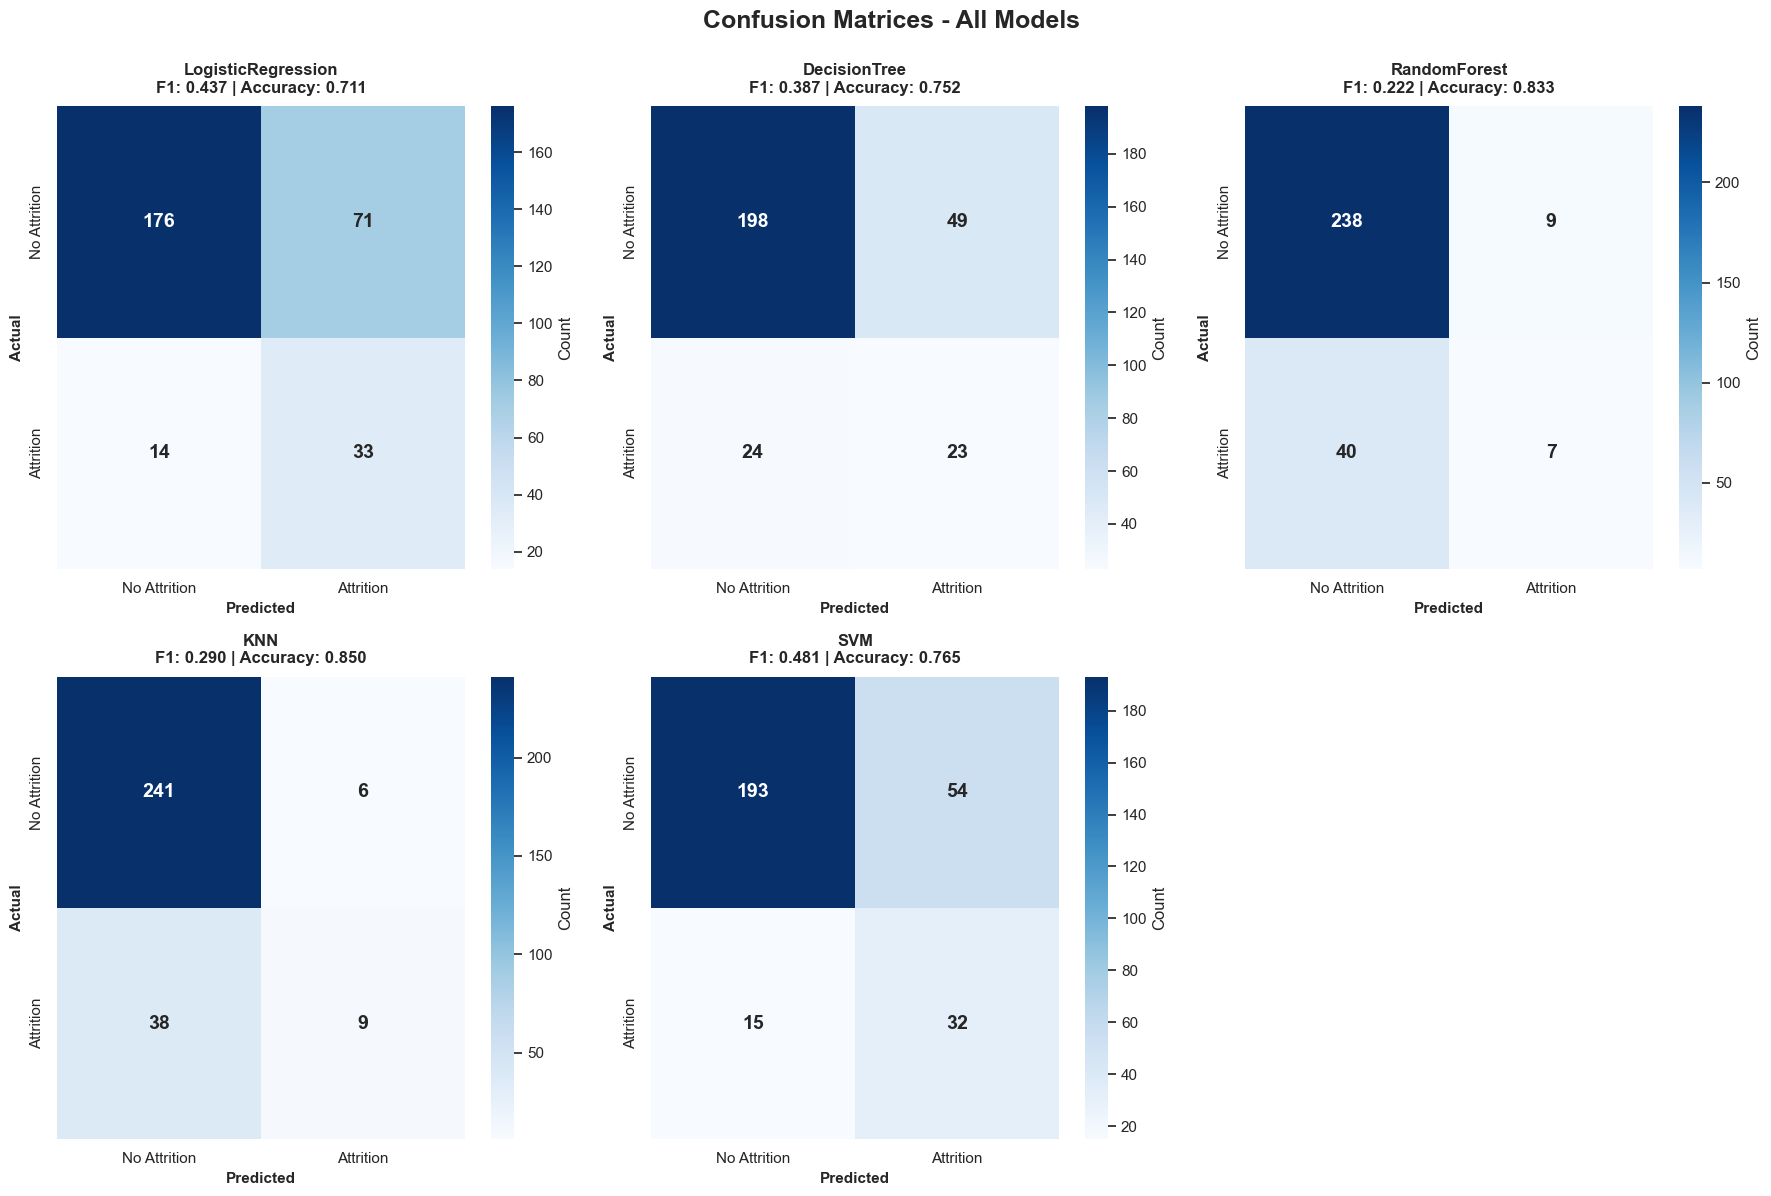

✓ Confusion matrices saved to models/confusion_matrices_all.png


In [26]:
# -------------------------
# 6.5. CONFUSION MATRICES - ALL MODELS
# -------------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices - All Models', 
             fontsize=18, fontweight='bold', y=0.995)

axes = axes.ravel()

for idx, (name, result) in enumerate(results.items()):
    # Get predictions
    y_pred = result['model'].predict(X_test_fs)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                cbar_kws={'label': 'Count'},
                xticklabels=['No Attrition', 'Attrition'],
                yticklabels=['No Attrition', 'Attrition'],
                annot_kws={'size': 14, 'weight': 'bold'})
    
    # Calculate metrics for subtitle
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    # Add title
    axes[idx].set_title(f'{name}\nF1: {f1:.3f} | Accuracy: {acc:.3f}',
                       fontsize=12, fontweight='bold', pad=10)
    axes[idx].set_ylabel('Actual', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=11, fontweight='bold')

if len(results) == 5:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig(str(models_folder / 'confusion_matrices_all.png'), 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Confusion matrices saved to models/confusion_matrices_all.png")


SVM MODEL - DETAILED ANALYSIS

Detailed Classification Report:
                  precision    recall  f1-score   support

No Attrition (0)     0.9279    0.7814    0.8484       247
   Attrition (1)     0.3721    0.6809    0.4812        47

        accuracy                         0.7653       294
       macro avg     0.6500    0.7311    0.6648       294
    weighted avg     0.8390    0.7653    0.7897       294



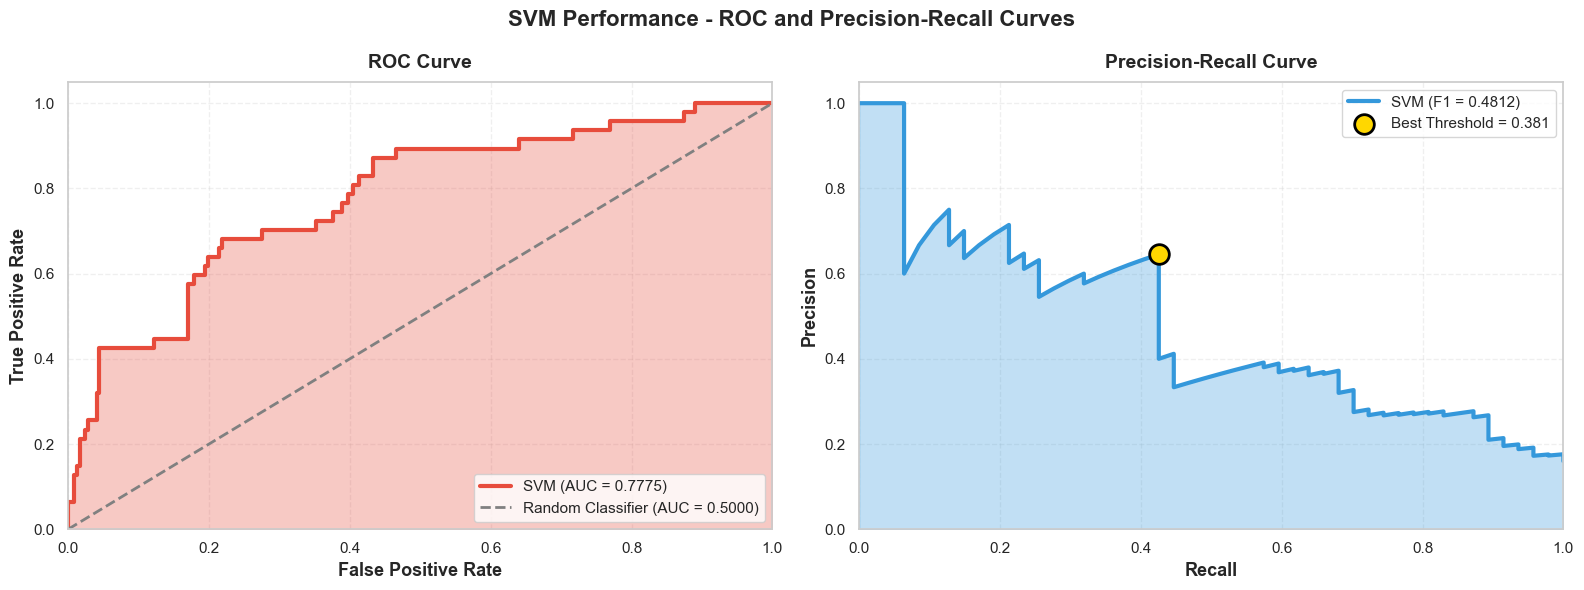


SVM PERFORMANCE SUMMARY
ROC-AUC Score:        0.7775
F1-Score:             0.4812
Optimal Threshold:    0.3807

Interpretation:
  • SVM can distinguish between classes with 77.8% accuracy
  • Achieves 68.1% recall (catches employees at risk)
  • Achieves 37.2% precision (accuracy when predicting attrition)
  • ✓ SVM is performing well on this dataset!


In [ ]:
# -------------------------
# 7. SVM DETAILED ANALYSIS - VERIFY PERFORMANCE
# -------------------------
print("\n" + "="*70)
print("SVM MODEL - DETAILED ANALYSIS")
print("="*70)

# Get SVM model and predictions
svm_model = results['SVM']['model']
y_pred_svm = svm_model.predict(X_test_fs)
y_proba_svm = svm_model.predict_proba(X_test_fs)[:, 1]

# Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_svm, 
                          target_names=['No Attrition (0)', 'Attrition (1)'],
                          digits=4))

# Create side-by-side ROC and PR curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('SVM Performance - ROC and Precision-Recall Curves', 
             fontsize=16, fontweight='bold')

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba_svm)
roc_auc = roc_auc_score(y_test, y_proba_svm)

axes[0].plot(fpr, tpr, color='#e74c3c', lw=3, 
             label=f'SVM (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', 
             label='Random Classifier (AUC = 0.5000)')
axes[0].fill_between(fpr, tpr, alpha=0.3, color='#e74c3c')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold', pad=10)
axes[0].legend(loc="lower right", fontsize=11)
axes[0].grid(alpha=0.3, linestyle='--')

# --- Precision-Recall Curve ---
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_svm)
f1_svm = f1_score(y_test, y_pred_svm)

# Calculate F1 scores 
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

axes[1].plot(recall, precision, color='#3498db', lw=3,
             label=f'SVM (F1 = {f1_svm:.4f})')
axes[1].fill_between(recall, precision, alpha=0.3, color='#3498db')
axes[1].scatter(recall[best_threshold_idx], precision[best_threshold_idx], 
                color='gold', s=200, zorder=5, edgecolor='black', linewidth=2,
                label=f'Best Threshold = {best_threshold:.3f}')
axes[1].set_xlabel('Recall', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=13, fontweight='bold')
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold', pad=10)
axes[1].legend(loc="best", fontsize=11)
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])

plt.tight_layout()
plt.savefig(str(models_folder / 'svm_performance_curves.png'), 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Print summary
print("\n" + "="*70)
print("SVM PERFORMANCE SUMMARY")
print("="*70)
print(f"ROC-AUC Score:        {roc_auc:.4f}")
print(f"F1-Score:             {f1_svm:.4f}")
print(f"Optimal Threshold:    {best_threshold:.4f}")
print(f"\nInterpretation:")
print(f"  • SVM can distinguish between classes with {roc_auc:.1%} accuracy")
print(f"  • Achieves {recall_score(y_test, y_pred_svm):.1%} recall (catches employees at risk)")
print(f"  • Achieves {precision_score(y_test, y_pred_svm):.1%} precision (accuracy when predicting attrition)")
print("  • ✓ SVM is performing well on this dataset!")
print("="*70)

In [28]:
# -------------------------
# 7.5 Permutation Feature Importance (Example for RandomForest)
# -------------------------
rf_model = results["RandomForest"]["model"]
perm_importance = permutation_importance(rf_model, X_test_fs, y_test, n_repeats=10, random_state=42)
perm_df = pd.DataFrame({"feature": X_train_fs.columns, "importance": perm_importance.importances_mean})
perm_df = perm_df.sort_values(by="importance", ascending=False)
print("Permutation feature importance (RandomForest):")
print(perm_df.head(10))

Permutation feature importance (RandomForest):
                              feature  importance
2                        OverTime_Yes    0.011224
11              TrainingTimesLastYear    0.007143
5                      JobInvolvement    0.006463
19  Department_Research & Development    0.002041
15            YearsSinceLastPromotion    0.001701
8          Department_Human Resources    0.000000
9                   PerformanceRating    0.000000
0           JobRole_Research Director   -0.000340
10                        Gender_Male   -0.000340
17                         HourlyRate   -0.000680


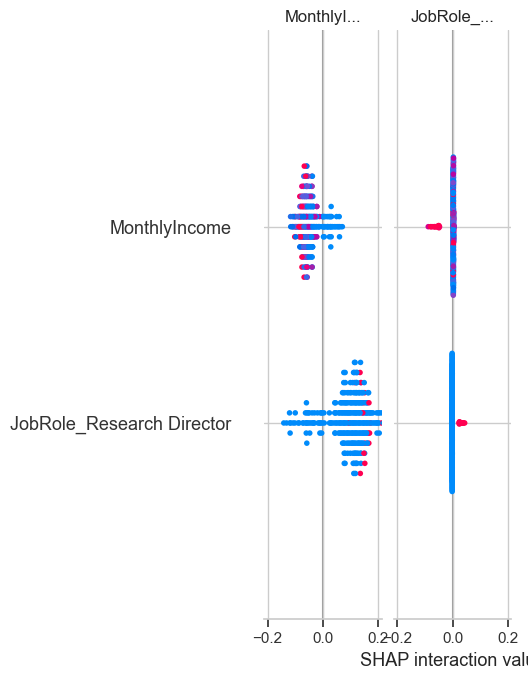

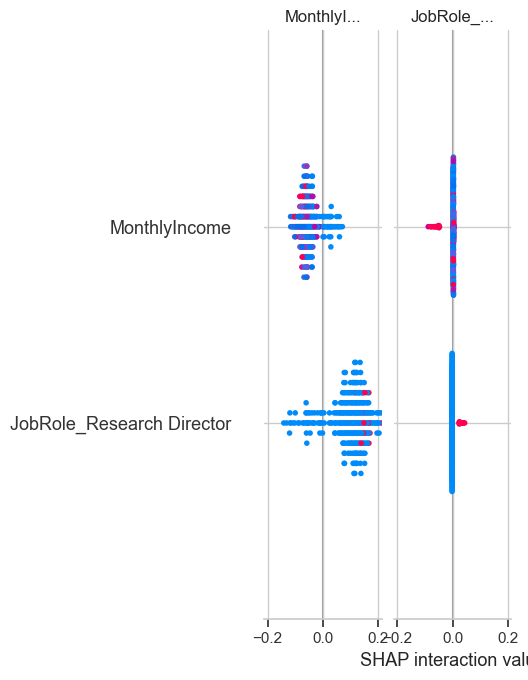

In [29]:
# -------------------------
# 8. SHAP Analysis for Final Model
# -------------------------
final_model = results["RandomForest"]["model"]  # pick best by business metric, e.g., recall/F1

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_fs)
shap.initjs()

# Global importance
sv = shap_values[1] if isinstance(shap_values, list) else shap_values
shap.summary_plot(sv, X_test_fs, plot_type="bar")

# Detailed summary
shap.summary_plot(sv, X_test_fs)

In [30]:
# -------------------------
# 9. Business Insights
# -------------------------
top_features = perm_df.head(5)["feature"].tolist()
print("Top features driving attrition risk:")
for f in top_features:
    median_val = X_test_fs[f].median()
    print(f"{f}: median value = {median_val}, higher/lower values may impact attrition risk")


Top features driving attrition risk:
OverTime_Yes: median value = 0.0, higher/lower values may impact attrition risk
TrainingTimesLastYear: median value = 0.2786385074391991, higher/lower values may impact attrition risk
JobInvolvement: median value = 0.3796721288811475, higher/lower values may impact attrition risk
Department_Research & Development: median value = 1.0, higher/lower values may impact attrition risk
YearsSinceLastPromotion: median value = -0.3724860758306997, higher/lower values may impact attrition risk
